# Imports

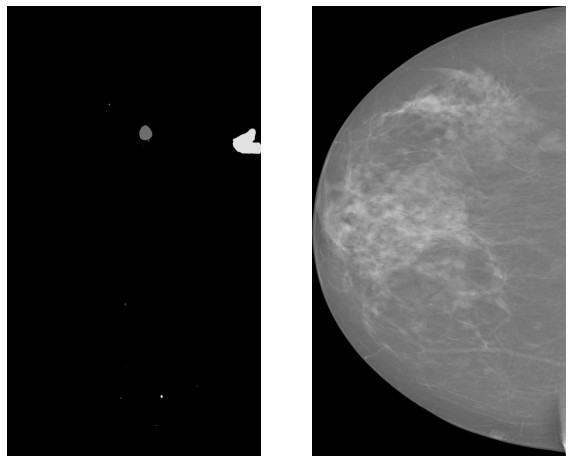

In [221]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

from pathlib import Path
from tqdm import tqdm
import cv2
import os
import ast


base_path = Path(os.path.abspath(os.path.join("data", "INbreast Release 1.0")))
csvs_path = base_path
png_folder = base_path/'AllPNGs/full_imgs'
masks_folder = base_path/'AllMasks/full_imgs'
dcm_folder = base_path/'AllDICOMs'
xml_folder = base_path/'AllXML'
image_filanme = "20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm"
image_metadata = {'img_id': image_filanme.split('_')[0],
                  'case_id': image_filanme.split('_')[1],
                  'side': image_filanme.split('_')[3],
                  'view': image_filanme.split('_')[4]}
dcm_filename = dcm_folder/image_filanme

roi_df = pd.read_csv(csvs_path/"rois_metadata.csv",
                     index_col=0)


def simple_im_show(img, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

def simple_im_show2(img, mask, figsize=(10, 10)):
    fig, ax = plt.subplots(1,2, figsize=figsize)
    ax[0].imshow(img, cmap='gray')
    ax[1].imshow(mask, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.show()

mask = cv2.imread(str(
    masks_folder/f'{image_metadata["img_id"]}_lesion_mask.png'), cv2.IMREAD_GRAYSCALE)
png = cv2.imread(
    str(png_folder/f'{image_metadata["img_id"]}.png'), cv2.IMREAD_ANYDEPTH)

simple_im_show2(mask, png)

# Image-processing

In [190]:
def plot_bboxes(image, bboxes):
    image = (image*255).astype(np.uint8)
    for bbox in bboxes:
        image = cv2.rectangle(image, bbox[0], bbox[1], 255, 3)
    return image

In [179]:
from skimage import restoration
from dehazing import dehaze

In [210]:
from skimage import data, img_as_float
from skimage import exposure

In [213]:
def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

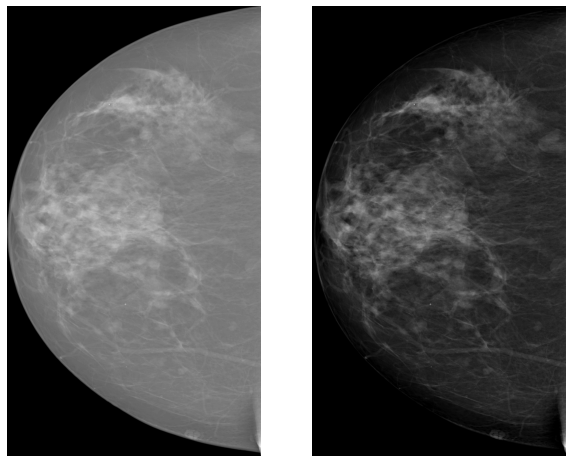

In [276]:
# Load an example image
img = png
# Contrast stretching
p1, p25, p50, p75, p100 = np.percentile(img, (1, 25, 50, 75, 100))
img_rescale = exposure.rescale_intensity(img, in_range=(p25, p100))

simple_im_show2(png, img_rescale)

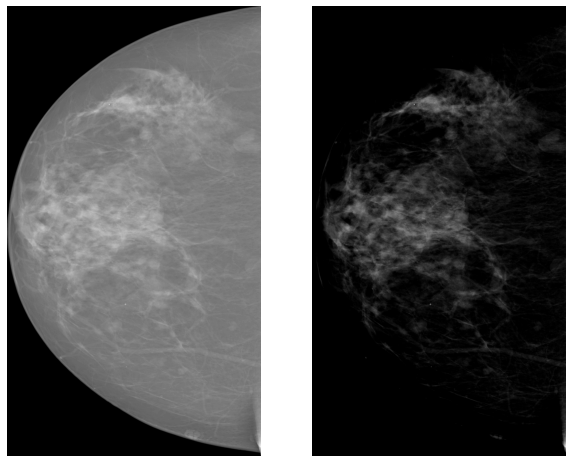

In [277]:
png = png.astype(np.float32)
normalized_png = png/png.max()

# Equalization
dehazed_image = exposure.rescale_intensity(img, in_range=(p50, p100))#dehaze(normalized_png, 0.9, 11, radius=40, eps=1e-5)

simple_im_show2(png, dehazed_image)

In [278]:
from ast import literal_eval

In [279]:
true_bboxes = image_rois.lesion_bbox_crop.values

In [280]:
cv2.imwrite("original.tiff", png)

True

In [281]:
cv2.imwrite("test.tiff", plot_bboxes(dehazed_image, true_bboxes))

True

This algorithm is sensitive to noise (in particular salt-and-pepper noise). If this is a problem in your image, you can apply mild gaussian smoothing before passing the image to this function.

In [282]:
background = restoration.rolling_ball(dehazed_image, radius=50, )

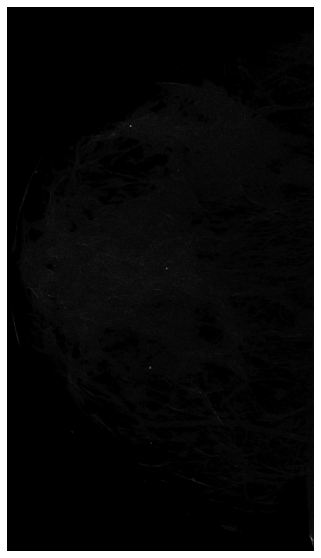

In [283]:
simple_im_show(dehazed_image - background)

In [284]:
background_substracted = dehazed_image - background

In [285]:
def sobel_filter(img):
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    return grad

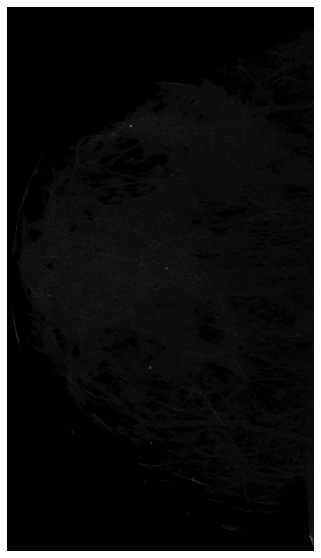

In [286]:
sobel_f1 = sobel_filter(background_substracted)
simple_im_show(sobel_f1)

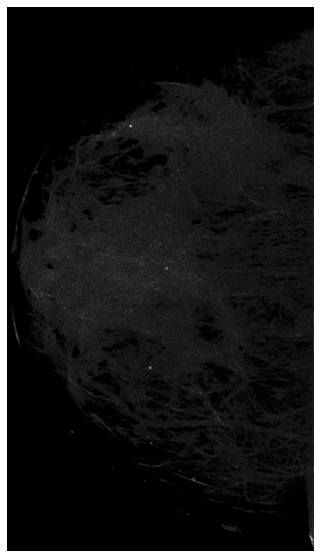

In [287]:
blured_iamge = cv2.GaussianBlur(sobel_f1, ksize=(0,0), sigmaX=2, sigmaY=2)
simple_im_show(blured_iamge)

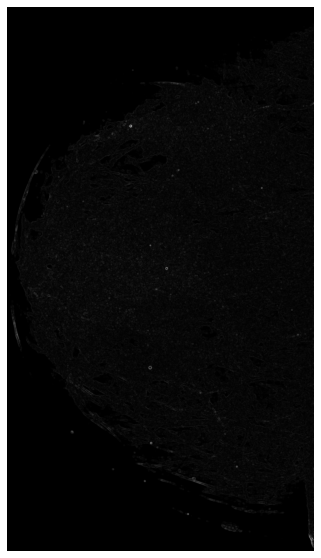

In [288]:
sobel_f2 = sobel_filter(blured_iamge)
simple_im_show(sobel_f2)

In [289]:
# cv2.imwrite("test.tiff", sobel_f2)

# Image Segmentation: Hough Hugh Haf

## Breast boundary cleaning

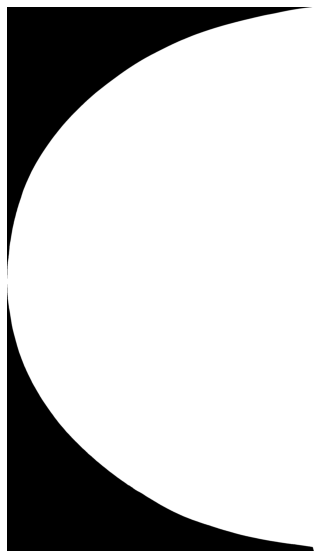

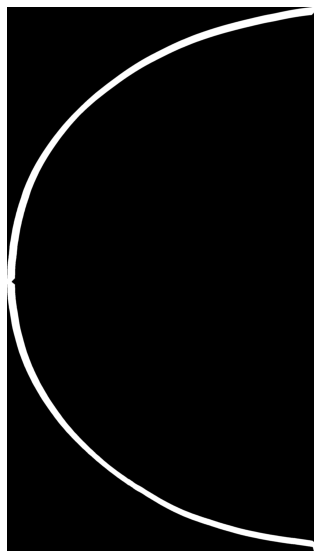

In [310]:
breast_mask = (png!=0).astype(np.uint8)
simple_im_show(breast_mask)
erosion_size = 10
structuring_element = cv2.getStructuringElement(cv2.MORPH_CROSS, (erosion_size, erosion_size))


breast_boundary_mask = (breast_mask - cv2.erode(breast_mask, structuring_element, iterations=10))

simple_im_show(breast_boundary_mask)

In [311]:
sobel_f2[breast_boundary_mask>0] = 0

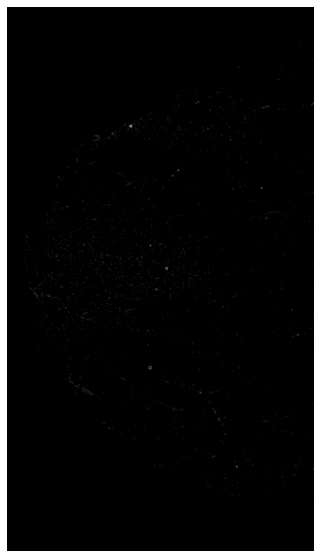

In [312]:
simple_im_show(sobel_f2)

In [313]:
cv2.imwrite("test_sobel.tiff", sobel_f2)

True

## First thresholding alpha1 
The grayscale pixel values of the pre-processed image are mapped into a new image such that values lower than a certain threshold become saturated

In [314]:
alpha1 = 0.97
alpha2 = 0.95

In [315]:
rmin = 2
rmax = 20

For InBreast we know that pixel size of 70 mm (microns), and 14-bit contrast resolution. == 1 pixel 0.07 milimiter

Microcalcifications, tiny spots of calcium deposits, whose diameter range from 0.1 to 1 mm

2 pixels to 20 pixels (1.4 to 14 to be more precise)

In [316]:
alpha1_intensity = np.quantile(sobel_f2[sobel_f2!=0], q=alpha1)
sobel_f2[sobel_f2 <= alpha1_intensity] = 0

In [317]:
gradient_normalized = (255*(sobel_f2/np.max(sobel_f2))).astype(np.uint8)

* param1 First method-specific parameter. In case of #HOUGH_GRADIENT and #HOUGH_GRADIENT_ALT, it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller). Note that #HOUGH_GRADIENT_ALT uses #Scharr algorithm to compute image derivatives, so the threshold value shough normally be higher, such as 300 or normally exposed and contrasty images.

* param2 Second method-specific parameter. In case of #HOUGH_GRADIENT, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first. In the case of #HOUGH_GRADIENT_ALT algorithm, this is the circle "perfectness" measure. The closer it to 1, the better shaped circles algorithm selects. In most cases 0.9 should be fine. If you want get better detection of small circles, you may decrease it to 0.85, 0.8 or even less. But then also try to limit the search range [minRadius, maxRadius] to avoid many false circles.

In [318]:
gradient_normalized[png == 0] = 0

In [334]:
circles = cv2.HoughCircles(gradient_normalized, cv2.HOUGH_GRADIENT, dp=1, minDist=5,
                               param1=400, param2=0.8,
                               minRadius=rmin, maxRadius=rmax)

In [335]:
cicles_img = np.zeros(gradient_normalized.shape)
if circles is not None:
    circles = np.uint16(np.around(circles))
    for i in circles[0, :]:
        center = (i[0], i[1])
        # circle center
        cv2.circle(cicles_img, center, 1, (0, 100, 100), 5)
        # circle outline
        radius = i[2]
        cv2.circle(cicles_img, center, radius, (255, 0, 255), 5)


In [336]:
print(len(circles[0]))

595


In [349]:
cicles_img.max()

255.0

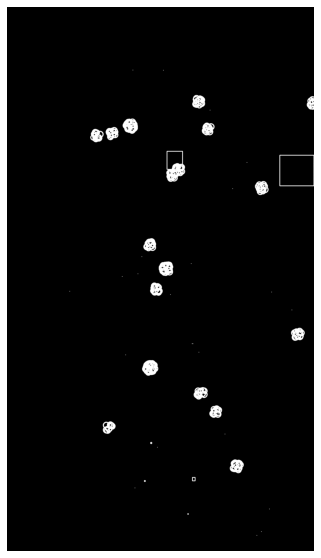

In [350]:
simple_im_show(plot_bboxes(cicles_img/255, true_bboxes))

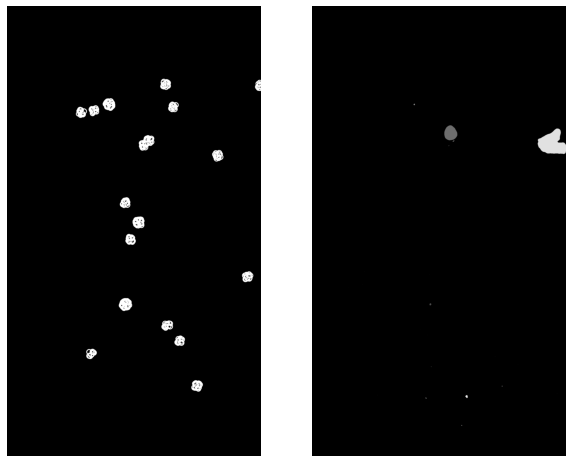

In [337]:
simple_im_show2(cicles_img, mask)

In [338]:
merged_mask_hough = np.zeros(cicles_img.shape + (3,))
merged_mask_hough[:,:,0] = (cicles_img!=0)*255

merged_mask_true= np.zeros(mask.shape + (3,))
merged_mask_true[:,:,1] = (mask!=0)*255

alpha = 0.5
beta = 0.5

dst = cv2.addWeighted(merged_mask_hough, alpha, merged_mask_true, beta, 0.0)


In [351]:
# cv2.imwrite("test.tiff", plot_bboxes(cicles_img/255, true_bboxes))

True

In [341]:
image_rois = roi_df[(roi_df.case_id == image_metadata['case_id'])&(roi_df.img_id == int(image_metadata['img_id']))]
image_rois['lesion_bbox'] = image_rois.lesion_bbox.apply(ast.literal_eval)
image_rois['lesion_bbox_crop'] = image_rois.lesion_bbox_crop.apply(ast.literal_eval)

/tmp/ipykernel_34916/2232698895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_rois['lesion_bbox'] = image_rois.lesion_bbox.apply(ast.literal_eval)
/tmp/ipykernel_34916/2232698895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_rois['lesion_bbox_crop'] = image_rois.lesion_bbox_crop.apply(ast.literal_eval)


In [342]:
circles

array([[[ 786,  756,    9],
        [ 910, 2296,    6],
        [1462, 2926,    6],
        ...,
        [1236, 2450,    2],
        [1342, 2592,   19],
        [ 988, 1658,   19]]], dtype=uint16)

In [343]:
def circle_in_bbox(circle:tuple, bbox_coords:np.ndarray):
    for roi_idx, roi in enumerate(bbox_coords):
        # checks if circle center is in ROI bbox
        if (roi[0][0] <= circle[0] <= roi[1][0] and
            roi[0][1] <= circle[1] <= roi[1][1]):
            return roi_idx
        # checks if a ROI is just a point and if it is  is inside a circle bbox
        if (roi[0][0]==roi[1][0] and 
            circle[0] - circle[2] <= roi[0][0] <= circle[0] + circle[2] and 
            circle[1] - circle[2] <= roi[0][1] <= circle[1] + circle[2]):
            return roi_idx
    return None


In [344]:
mC_bboxes = image_rois[image_rois.lesion_type == 'calcification'].lesion_bbox_crop.values
TP_mC = []
TP_circles = []
tp_mC_idxs = []
FP  = []


for circle in circles[0]:
    res = circle_in_bbox(circle, mC_bboxes)
    if res:
        tp_mC_idxs.append(res)
        TP_circles.append(circle)
    else:
        FP.append(circle)

TP_mC = mC_bboxes[tp_mC_idxs]
FN = np.delete(mC_bboxes, tp_mC_idxs)

precision = len(TP_circles)/(len(TP_circles) + len(FP))
recall =len(TP_circles)/(len(TP_circles) + len(FN))

print(f'TP\tFP\n{len(TP_circles)}\t{len(FP)}\nFN\tTN\n{len(FN)}\t*\n\n')
print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {(2*recall*precision)/(precision+recall)}")

TP	FP
83	512
FN	TN
28	*


Precision: 0.13949579831932774
Recall: 0.7477477477477478
F1-score: 0.23512747875354106


In [274]:
def sobel_gradient(img):
    grad_x = cv2.Sobel(img, cv2.CV_32F, 1, 0)
    grad_y = cv2.Sobel(img, cv2.CV_32F, 0, 1)
    grad = np.sqrt(grad_x**2 + grad_y**2)
    return grad

def detect_mC(image):
    # 1. CONTRAST ENHANCEMENT - EQUALIZATION
    image = png.astype(np.float32)
    # OTHER NORMALIZATION MAUBE
    normalized_image = image/image.max()
    dehazed_image = dehaze(normalized_image, 0.9, 11, radius=40, eps=1e-5)

    #  2. BACKGROUND EXTRACTION
    background = restoration.rolling_ball(dehazed_image, radius=50, )
    background_substracted = dehazed_image - background

    # 3. SOBEL-GAUSSIAN-SOBEL
    sobel_f1 = sobel_gradient(background_substracted)
    blured_iamge = cv2.GaussianBlur(sobel_f1,(7,7),0)
    sobel_f2 = sobel_filter(blured_iamge)

    # 4. BOUNDARY CLEANING

    breast_mask = (sobel_f2!=0).astype(np.uint8)
    erosion_size = 10
    structuring_element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (erosion_size, erosion_size))
    breast_boundary_mask = (breast_mask - cv2.erode(breast_mask, structuring_element, iterations=10))
    sobel_f2[breast_boundary_mask>0] = 0

    # 5. FIRST GLOBAL THRESHOLDING
    alpha1 = 0.97
    # !!!SELECT FOR EVALUATION ONLY BREAST PIXELS!!!
    alpha1_intensity = np.quantile(sobel_f2, q=alpha1)
    sobel_f2[sobel_f2 <= alpha1_intensity] = 0

    # 6. FIRST HOUGH

    rmin = 2
    rmax = 20
    gradient_normalized = (255*(sobel_f2/np.max(sobel_f2))).astype(np.uint8)
    circles = cv2.HoughCircles(gradient_normalized, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                               param1=400, param2=10,
                               minRadius=rmin, maxRadius=rmax)


    alpha2 = 0.95
    return circles


In [98]:
mC_bboxes = image_rois[image_rois.lesion_type == 'calcification'].lesion_bbox_crop.values
TP_mC = []
TP_circles = []
tp_mC_idxs = []
FP  = []


for circle in circles[0]:
    res = circle_in_bbox(circle, mC_bboxes)
    if res:
        tp_mC_idxs.append(res)
        TP_circles.append(circle)
    else:
        FP.append(circle)

TP_mC = mC_bboxes[tp_mC_idxs]
FN = np.delete(mC_bboxes, tp_mC_idxs)

precision = len(TP_circles)/(len(TP_circles) + len(FP))
recall =len(TP_circles)/(len(TP_circles) + len(FN))

print(f'TP\tFP\n{len(TP_circles)}\t{len(FP)}\nFN\tTN\n{len(FN)}\t*\n\n')
print(f"Precision: {precision}\nRecall: {recall}\nF1-score: {(2*recall*precision)/(precision+recall)}")

In [38]:
c 

array([[[ 910.5, 2294.5,    9.6],
        [ 786.5,  756.5,    8. ],
        [1017.5, 1664.5,    8.2],
        [ 670.5,  807.5,    3.8],
        [ 917.5, 2775.5,    3.3],
        [ 912.5, 1517.5,    4. ]]], dtype=float32)

In [39]:
circles

array([[[ 910, 2294,   10],
        [ 786,  756,    8],
        [1018, 1664,    8],
        [ 670,  808,    4],
        [ 918, 2776,    3],
        [ 912, 1518,    4]]], dtype=uint16)

The FROC curve is defined as the plot of sensitivity versus the average number of false-positives per image.

`sensitivity = TP/(TP + FN)`


    # for every predicted bbox find all rois with passing centre_dist and IoU
    # create a mapping between pred_roi -- conf -- all_mapped_true_rois
    # for all values of confidence:
    #    select rois with confidence >= and calculate for them average sensitivity and number of FP
    # return a dict with values {conf: [sens, FPi]}

In [30]:
def bbox_comparison(mask, rois_df, true_bboxes:np.ndarray, predicted_bboxes:np.ndarray, prediction_confidences:np.ndarray, max_centre_dist:float, min_IoU:float):
    """Calculates data for fROC curve plot based on bounding boxes.

    Args:
        true_bboxes (np.ndarray): Array of predicted bboxes containing for each bbox
            [(top_left_coordinates), (bottom_right_coordinates), (centre_coordinates)]
        predicted_bboxes (np.ndarray): Array of predicted bboxes of same shape as true_bboxes
        max_centre_dist (float): Maximum distance between bbox centres for a pair of bboxes to be
            considered a match
        min_IoU (float): Minimum IoU area of true and predicted bboxes for them to be considered mapped

    Returns:
        np.ndarray: 2D fROC data array
    """

    mapping_results = []
    # go through predicted bboxes and try to find ROI that correspond to them
    for bbox_idx, bbox in predicted_bboxes:

        mapping_result = {'prediction_confidence':prediction_confidences[bbox_idx]}
        mapping_result['bbox_idx'] = bbox_idx
        mapping_result['mapped_rois'] = []
        
        # slice mask in the place of the predicted bbox and find which ROIs intersect with it
        intersected_rois = np.unique(mask[bbox[0][0]:bbox[1][0], bbox[0][1]:bbox[1][1]])
        
        # flag to check if able to find a true ROI for a given predicted bbox
        found_match = False 

        # check each ROI for the correspondance to parameters
        for roi_idx, roi in roi_df[roi_df.index_in_image.isin(intersected_rois)].iterrows():
            
            # calculate IoU
            pred_bbox_mask = cv2.rectangle(np.zeros(mask.shape), bbox[0], bbox[1], 1, -1).astype(np.bool8)
            roi_mask = mask == roi_idx
            iou = (pred_bbox_mask & roi_mask).sum() / (pred_bbox_mask | roi_mask).sum()

            roi_center = np.array(roi['center_crop'])
            pred_center_= np.array(bbox[2])
            if np.linalg.norm(roi_center - pred_center_) <= max_centre_dist and \
                iou >= min_IoU:
                mapping_result['mapped_rois'].append(roi['index_in_image'])

    mapping_results.append(mapping_result)
    mapping_results_df = pd.DataFrame(mapping_results, index='bbox_idx')
    
    metrics = []
    for conf_thr in np.linspace(0.01, 0.99, 99):
        thresholded_df = mapping_results_df[mapping_results_df.prediction_confidence > conf_thr]
        TP_num = len(thresholded_df[thresholded_df.mapped_rois.apply(len)>0])
        FP_num = len(thresholded_df[thresholded_df.mapped_rois.apply(len)==0])

        # getting roi_idx of all successfully mapped ROIs
        succs_mapped_rois = np.unique(np.concatenate(thresholded_df['mapped_rois'].values))
        
        FN_num = len(true_bboxes) - len(succs_mapped_rois)

        sensitivity = TP_num/(TP_num + FN_num)
        metrics.append({'conf_thr':conf_thr, 'TP_num':TP_num, 'FP_num':FP_num,
                       'FN_num':FN_num, 'sensitivity':sensitivity})
    return metrics

def plot_bbox(image, true_bboxes:np.ndarray, predicted_bboxes:np.ndarray, prediction_confidences:np.ndarray):
    for tr_bbb in true_bboxes:
        image = cv2.rectangle(image, tr_bbb[0], tr_bbb[1], cv2.green, thickness=2)
        
    for pr_bb_idx, pr_bb in enumerate(predicted_bboxes):
        image = cv2.rectangle(image, pr_bb[0], pr_bb[1], cv2.red, thickness=2)

        image = cv2.putText(image, f'{prediction_confidences[pr_bb_idx]}', pr_bb[1])
    simple_im_show(image)
    return image

In [131]:
def plot_bbox(image, true_bboxes:np.ndarray, predicted_bboxes:np.ndarray, prediction_confidences:np.ndarray):
    for tr_bbb in true_bboxes:
        image = cv2.rectangle(image, tr_bbb[0], tr_bbb[1], cv2.green, thickness=2)
        
    for pr_bb_idx, pr_bb in enumerate(predicted_bboxes):
        image = cv2.rectangle(image, pr_bb[0], pr_bb[1], cv2.red, thickness=2)

        image = cv2.putText(image, f'{prediction_confidences[pr_bb_idx]}', pr_bb[1])
    simple_im_show(image)
    return image